In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import scipy
import sys

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

In [3]:
def get_objectives(df, normal_threshold_exit1, attack_threshold_exit1, normal_threshold_exit2, attack_threshold_exit2):
    f_n_exit1 = 'y_exit_1 == 0 and cnf_exit_1 >= @normal_threshold_exit1'
    f_a_exit1 = 'y_exit_1 == 1 and cnf_exit_1 >= @attack_threshold_exit1'

    f_n_exit2 = 'y_exit_2 == 0 and cnf_exit_2 >= @normal_threshold_exit2'
    f_a_exit2 = 'y_exit_2 == 1 and cnf_exit_2 >= @attack_threshold_exit2'

    exit1_normal = df.query(f_n_exit1)
    exit1_attack = df.query(f_a_exit1)

    exit2 = df.query(f'not ({f_n_exit1}) and not ({f_a_exit1})')

    exit2_normal = exit2.query(f_n_exit2)
    exit2_attack = exit2.query(f_a_exit2)

    not_accepted = exit2.query(f'not ({f_n_exit2}) and not ({f_a_exit2})')

    total = df['y'].count()

    exit1_normal_cnt = exit1_normal['y'].count()
    exit1_attack_cnt = exit1_attack['y'].count()
    exit2_normal_cnt = exit2_normal['y'].count()
    exit2_attack_cnt = exit2_attack['y'].count()

    accepted = exit1_normal_cnt + exit1_attack_cnt + exit2_normal_cnt + exit2_attack_cnt

    acceptance_rate = accepted / total

    correct = exit1_normal.query('y == y_exit_1')['y'].count() + \
              exit1_attack.query('y == y_exit_1')['y'].count() + \
              exit2_normal.query('y == y_exit_2')['y'].count() + \
              exit2_attack.query('y == y_exit_2')['y'].count()

    accuracy = correct / accepted

    exit1_total_time = exit1_normal['bb_time_exit_1'].sum() + exit1_normal['exit_time_exit_1'].sum() + \
                       exit1_attack['bb_time_exit_1'].sum() + exit1_attack['exit_time_exit_1'].sum()

    exit2_total_time = exit2_normal['bb_time_exit_1'].sum() + exit2_normal['bb_time_exit_2'].sum() + exit2_normal['exit_time_exit_2'].sum() + \
                       exit2_attack['bb_time_exit_1'].sum() + exit2_attack['bb_time_exit_2'].sum() + exit2_attack['exit_time_exit_2'].sum()

    not_accepted_total_time = not_accepted['bb_time_exit_1'].sum() + not_accepted['bb_time_exit_2'].sum() + not_accepted['exit_time_exit_2'].sum()

    total_time = exit1_total_time + exit2_total_time + not_accepted_total_time

    # print(f"Total: {total}")
    # print(f"exit1_normal_cnt: {exit1_normal_cnt}, exit1_attack_cnt: {exit1_attack_cnt}")
    # print(f"exit2_normal_cnt: {exit2_normal_cnt}, exit2_attack_cnt: {exit2_attack_cnt}")
    # print(f"Accepted: {accepted}, Accepted: {total - not_accepted['y'].count()}")
    # print(f"exit1_total_time: {exit1_total_time:.4f}, exit2_total_time: {exit2_total_time:.4f}, not_accepted_total_time: {not_accepted_total_time:.4f}")
    # print(f"exit1_rate: {100 * ( exit1_normal_cnt + exit1_attack_cnt ) / total:.2f}, exit2_rate: {100 * ( exit2_normal_cnt + exit2_attack_cnt ) / total:.2f}")
    # print(f"Accuracy: {100 * accuracy:.2f}, Acceptance: {100 * acceptance_rate:.2f}, Average Time: {1e6 * total_time / total:.2f}")

    return [ accuracy, acceptance_rate, 1e6 * total_time / total ]

def plot(directory, *cnfs):
    datapoints = {
        'network' : network,
        'labels' : [],
        'accuracy_e1' : [],
        'accuracy_e2' : [],
        'accuracy_model' : [],
        'acceptance_e1' : [],
        'acceptance_e2' : [],
        'acceptance_model' : [],
        'time_e1' : [],
        'time_e2' : [],
        'time_model' : [],
    }

    print(cnfs)

    for year in range(2016, 2020):
        year = f'{year:04d}'
        for month in range(1, 13):
            month = f'{month:02d}'
            glob = f'{year}_{month}'
            csv = os.path.join(directory, f'{glob}.csv')
            df = pd.read_csv(csv)
            
            accuracy_e1, acceptance_e1, time_e1 = get_objectives(df, 0, 0, 1, 1)
            accuracy_e2, acceptance_e2, time_e2 = get_objectives(df, 2, 2, 0, 0)
            accuracy, acceptance, time = get_objectives(df, *cnfs)

            datapoints['labels'].append(glob)
            datapoints['accuracy_e1'].append(accuracy_e1)
            datapoints['accuracy_e2'].append(accuracy_e2)
            datapoints['accuracy_model'].append(accuracy)
            datapoints['acceptance_e1'].append(acceptance_e1)
            datapoints['acceptance_e2'].append(acceptance_e2)
            datapoints['acceptance_model'].append(acceptance)
            datapoints['time_e1'].append(time_e1)
            datapoints['time_e2'].append(time_e2)
            datapoints['time_model'].append(time)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout='constrained')
    fig.autofmt_xdate(rotation=90)
    plt.title(f"Accuracy {datapoints['network']} - min cnf: {cnfs}")

    axs[0].plot(datapoints['labels'], datapoints['accuracy_e1'], label='accuracy_e1')
    axs[0].plot(datapoints['accuracy_e2'], label='accuracy_e2')
    axs[0].plot(datapoints['accuracy_model'], label='accuracy_model')
    axs[0].plot(datapoints['acceptance_model'], label='acceptance_model')            
    axs[0].legend()

    axs[1].plot(datapoints['labels'], datapoints['time_e1'], label='time_e1')
    axs[1].plot(datapoints['time_e2'], label='time_e2')
    axs[1].plot(datapoints['time_model'], label='time_model')
    axs[1].legend()
    
    plt.show

In [8]:
network = 'alexnet'

## Which one to check
file = f'/home/jasimioni/ppgia/earlyexit/jupyter/nsgaresults/{network}_x_f_2016_23.sav'

directories = {
    'alexnet'   : '/home/jasimioni/ppgia/earlyexit/AlexNet/evaluations/saves/2023-08-20-01-53-10/epoch_19_90.2_91.3.pth/',
    'mobilenet' : '/home/jasimioni/ppgia/earlyexit/MobileNet/evaluations/saves/MobileNetV2WithExits/2023-08-20-05-20-25/epoch_19_89.7_90.9.pth',
}

directory = directories[network]

with open(file, 'rb') as f:
    X, F, min_time, max_time, accuracy_e1, acceptance_e1, accuracy_e2, acceptance_e2 = pickle.load(f)

results = []

print(f'e1: Accuracy: {accuracy_e1:.2f}% - Acceptance: {acceptance_e1}% - Cost: {min_time:.2f}us')
print(f'e2: Accuracy: {accuracy_e2:.2f}% - Acceptance: {acceptance_e2}% - Cost: {max_time:.2f}us\n')

for i in range(len(F)):
    f = F[i]
    x = X[i]
    quality = 100 * (1 - sum(f) / len(f))
    results.append([ quality, *f, *x ])

valid_results = []
best_time = None
best_accuracy = None
best_score = None

for i, r in enumerate(sorted(results, key=lambda x: x[0], reverse=True)):
    # Acceptance at least 85%
    if r[2] > 0.15:
        continue

    if best_score is None:
        best_score = r

    if best_time is None or r[3] < best_time[3]:
        best_time = r

    if best_accuracy is None or r[1] < best_accuracy[1]:
        best_accuracy = r

    # print(f'{i:02d}: {r[0]:.2f}% => {100 * (1 - r[1]):.2f}% : {100 * (1 - r[2]):.2f}% : {min_time + (r[3] * (max_time - min_time)):.2f}us', end='')
    # print(f'\t{r[4]:.4f} : {r[5]:.4f} : {r[6]:.4f} : {r[7]:.4f}')

print('Score => Accuracy : Acceptance : Cost\tn_e1 : a_e1 : n_e2 : a_e2')

r = best_score
print(f'Melhor score:')
print(f'{i:02d}: {r[0]:.2f}% => {100 * (1 - r[1]):.2f}% : {100 * (1 - r[2]):.2f}% : {min_time + (r[3] * (max_time - min_time)):.2f}us', end='')
print(f'\t{r[4]:.4f} : {r[5]:.4f} : {r[6]:.4f} : {r[7]:.4f}\n')

r = best_accuracy
print(f'Melhor accuracy (com acceptance > 85%):')
print(f'{i:02d}: {r[0]:.2f}% => {100 * (1 - r[1]):.2f}% : {100 * (1 - r[2]):.2f}% : {min_time + (r[3] * (max_time - min_time)):.2f}us', end='')
print(f'\t{r[4]:.4f} : {r[5]:.4f} : {r[6]:.4f} : {r[7]:.4f}\n')

r = best_time
print(f'Melhor tempo (com acceptance > 85%):')
print(f'{i:02d}: {r[0]:.2f}% => {100 * (1 - r[1]):.2f}% : {100 * (1 - r[2]):.2f}% : {min_time + (r[3] * (max_time - min_time)):.2f}us', end='')
print(f'\t{r[4]:.4f} : {r[5]:.4f} : {r[6]:.4f} : {r[7]:.4f}')


e1: Accuracy: 89.55% - Acceptance: 100% - Cost: 0.61us
e2: Accuracy: 90.26% - Acceptance: 100% - Cost: 1.54us

Score => Accuracy : Acceptance : Cost	n_e1 : a_e1 : n_e2 : a_e2
Melhor score:
99: 96.52% => 89.55% : 100.00% : 0.61us	0.5000 : 0.5000 : 0.9602 : 0.5419

Melhor accuracy (com acceptance > 85%):
99: 78.24% => 93.68% : 86.73% : 1.04us	0.8792 : 0.9703 : 0.9475 : 0.8626

Melhor tempo (com acceptance > 85%):
99: 96.52% => 89.55% : 100.00% : 0.61us	0.5000 : 0.5000 : 0.9602 : 0.5419


(0.5000038229100314, 0.5000047377146011, 0.9601591011252959, 0.5419136353286604)


C:\Users\jasim\AppData\Local\Temp\ipykernel_22276\2911002101.py:97: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


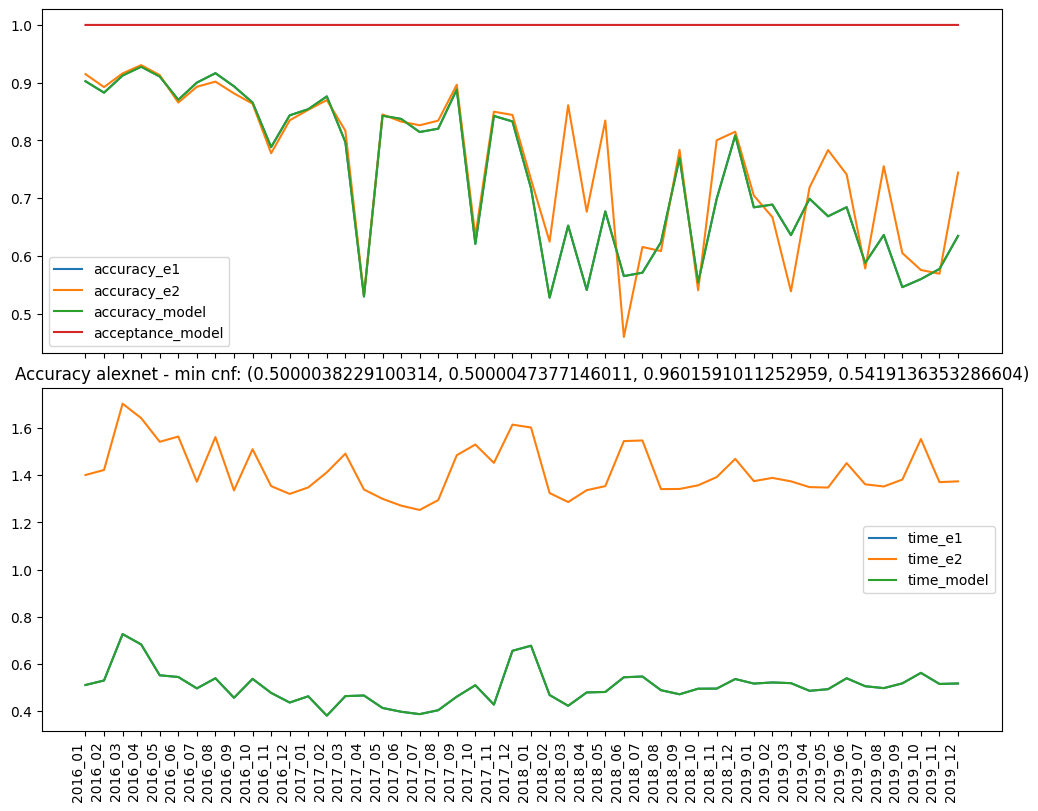

In [4]:
r = best_score
plot(directory, *r[4:])

(0.8791873239582018, 0.9702799660744145, 0.9474573388207232, 0.8625951416136262)


C:\Users\jasim\AppData\Local\Temp\ipykernel_22276\2911002101.py:97: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


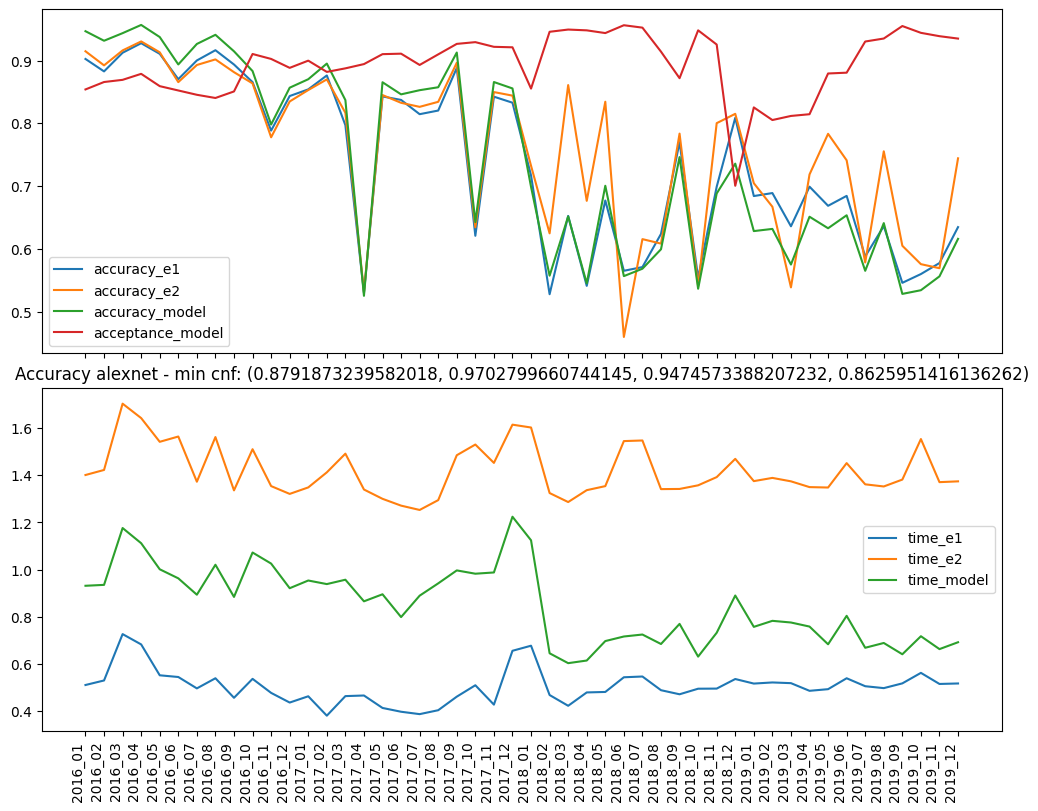

In [5]:
r = best_accuracy
plot(directory, *r[4:])

(0.5000038229100314, 0.5000047377146011, 0.9601591011252959, 0.5419136353286604)


C:\Users\jasim\AppData\Local\Temp\ipykernel_22276\2911002101.py:97: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


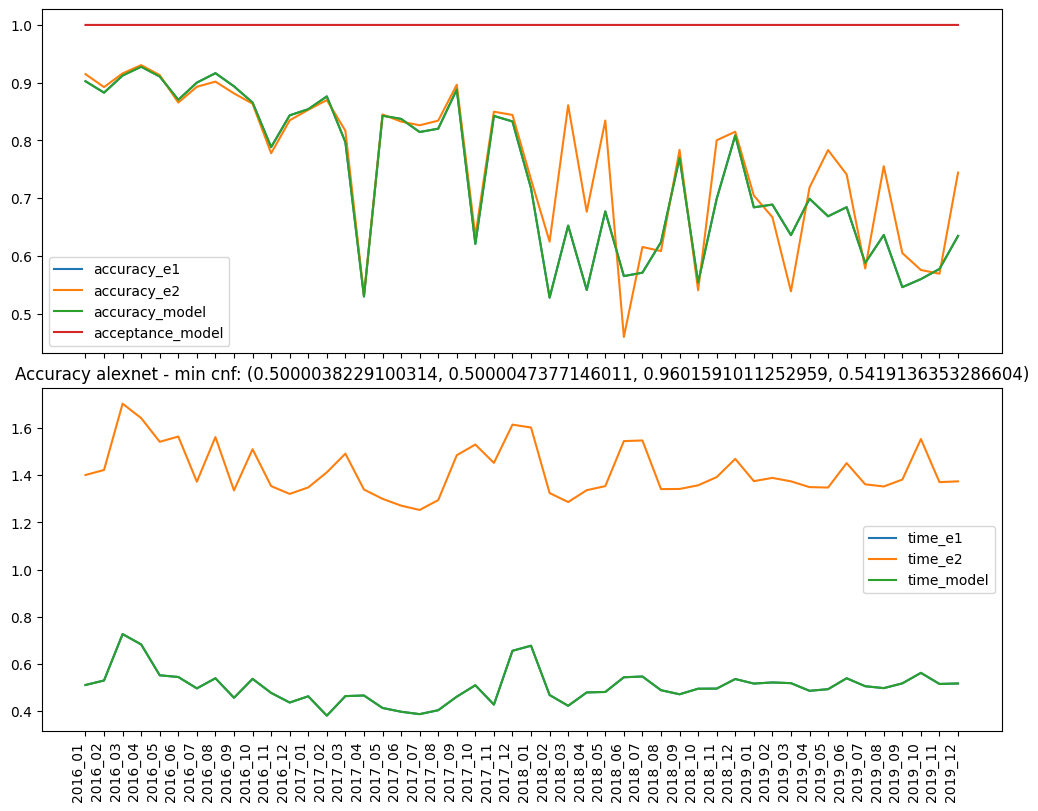

In [6]:
r = best_time
plot(directory, *r[4:])